In [1]:
from fastai.text import *
import html
import pandas as pd

/root/py36venv/lib64/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


## Load INSPIRE data

In [2]:
BOS = 'xbos'  # beginning-of-sentence tag
FLD = 'xfld'  # data field tag

PATH=Path('inspire_data/')

In [3]:
CLAS_PATH=Path('inspire_data/inspire_clas')
CLAS_PATH.mkdir(exist_ok=True)

LM_PATH=Path('inspire_data/inspire_lm/')
LM_PATH.mkdir(exist_ok=True)

In [4]:
inspire_data = pd.read_pickle('inspire_data/inspire_data.df')

inspire_data = inspire_data.sample(frac=1).reset_index(drop=True)
inspire_data = inspire_data[['labels', 'text']]

## Prepare data for the Language Model

In [28]:
# Split the data into training (80 %) and validation (20 % splits)

df_trn, df_val = sklearn.model_selection.train_test_split(
    inspire_data, test_size=0.2)

df_trn = df_trn.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)

trn_texts = np.array(df_trn['text'])
val_texts = np.array(df_val['text'])

In [29]:
print('{}, {}'. format(len(trn_texts), len(val_texts)))

148805, 37202


In [30]:
CLASSES = ['rejected', 'noncore', 'core']

df_trn.to_csv(CLAS_PATH/'train.csv', header=False, index=False)
df_val.to_csv(CLAS_PATH/'test.csv', header=False, index=False)


(CLAS_PATH/'classes.txt').open('w').writelines(f'{o}\n' for o in CLASSES)

In [31]:
col_names = ['labels','text']

df_trn = pd.DataFrame({'text':trn_texts, 'labels':[0]*len(trn_texts)}, columns=col_names)
df_val = pd.DataFrame({'text':val_texts, 'labels':[0]*len(val_texts)}, columns=col_names)

df_trn.to_csv(LM_PATH/'train.csv', header=False, index=False)
df_val.to_csv(LM_PATH/'test.csv', header=False, index=False)

## Language Model Tokens

In [36]:
chunksize=24000

In [37]:
re1 = re.compile(r'  +')

def fixup(x):
    x = x.replace('#39;', "'").replace('amp;', '&').replace('#146;', "'").replace(
        'nbsp;', ' ').replace('#36;', '$').replace('\\n', "\n").replace('quot;', "'").replace(
        '<br />', "\n").replace('\\"', '"').replace('<unk>','u_n').replace(' @.@ ','.').replace(
        ' @-@ ','-').replace('\\', ' \\ ')
    return re1.sub(' ', html.unescape(x))

In [38]:
def get_texts(df, n_lbls=1):
    labels = df.iloc[:,range(n_lbls)].values.astype(np.int64)
    texts = f'\n{BOS} {FLD} 1 ' + df[n_lbls].astype(str)
    for i in range(n_lbls+1, len(df.columns)): texts += f' {FLD} {i-n_lbls} ' + df[i].astype(str)
    texts = list(texts.apply(fixup).values)

    tok = Tokenizer().proc_all_mp(partition_by_cores(texts))
    return tok, list(labels)

In [39]:
def get_all(df, n_lbls):
    tok, labels = [], []
    for i, r in enumerate(df):
        print(i)
        tok_, labels_ = get_texts(r, n_lbls)
        tok += tok_;
        labels += labels_
    return tok, labels

In [36]:
df_trn = pd.read_csv(LM_PATH/'train.csv', header=None, chunksize=chunksize)
df_val = pd.read_csv(LM_PATH/'test.csv', header=None, chunksize=chunksize)

In [37]:
tok_trn, trn_labels = get_all(df_trn, 1)
tok_val, val_labels = get_all(df_val, 1)

0
1
2
3
4
5
6
0
1


In [53]:
inspire_data.loc[0]['text']

'Magnetic moments of even rare-earth nuclei in the cranked HFB approach <ENDTITLE> Magnetic moments of yrast levels of a large number of even-even rare-earth nuclei have been calculated using a simple version of the cranked Hartree-Fock-Bogoliubov (CHFB) model. In order to study the sensitivity of the calculated results to the input values of spherical single-particle energies, the calculation has been performed with two different sets of these energies, which are widely used in the literature. It is found that with proper choice of spherical single-particle energies, the CHFB formalism, in its simple version, is quite capable of reproducing the observed spin dependence of g -factors from Sm to Os nuclei.'

In [38]:
len(tok_trn)

148805

In [39]:
(LM_PATH/'tmp').mkdir(exist_ok=True)

In [40]:
np.save(LM_PATH/'tmp'/'tok_trn.npy', tok_trn)
np.save(LM_PATH/'tmp'/'tok_val.npy', tok_val)

In [41]:
tok_trn = np.load(LM_PATH/'tmp'/'tok_trn.npy')
tok_val = np.load(LM_PATH/'tmp'/'tok_val.npy')

In [42]:
freq = Counter(p for o in tok_trn for p in o)
freq.most_common(25)

[('the', 1667298),
 ('of', 968448),
 ('.', 799009),
 (',', 759719),
 ('and', 572370),
 ('-', 560371),
 ('in', 494015),
 ('a', 479713),
 ('t_up', 468760),
 ('to', 404409),
 ('for', 273420),
 ('is', 266171),
 ('we', 241120),
 (')', 231714),
 ('with', 216990),
 ('(', 202924),
 ('$', 183265),
 ('\\', 181321),
 ('1', 176249),
 ('\n', 168734),
 ('<', 163566),
 ('that', 161821),
 ('>', 159277),
 ('are', 158440),
 ('xbos', 148805)]

In [43]:
max_vocab = 60000
min_freq = 2

In [44]:
itos = [o for o,c in freq.most_common(max_vocab) if c>min_freq]
itos.insert(0, '_pad_')
itos.insert(0, '_unk_')

In [55]:
stoi = collections.defaultdict(lambda:0, {v:k for k,v in enumerate(itos)})
len(itos)

60002

In [56]:
trn_lm = np.array([[stoi[o] for o in p] for p in tok_trn])
val_lm = np.array([[stoi[o] for o in p] for p in tok_val])

In [57]:
np.save(LM_PATH/'tmp'/'trn_ids.npy', trn_lm)
np.save(LM_PATH/'tmp'/'val_ids.npy', val_lm)
pickle.dump(itos, open(LM_PATH/'tmp'/'itos.pkl', 'wb'))

In [5]:
trn_lm = np.load(LM_PATH/'tmp'/'trn_ids.npy')
val_lm = np.load(LM_PATH/'tmp'/'val_ids.npy')
itos = pickle.load(open(LM_PATH/'tmp'/'itos.pkl', 'rb'))

In [6]:
vs=len(itos)
vs,len(trn_lm)

(60002, 148805)

## wikitext103 conversion

In [60]:
# ! wget -nH -r -np -P {PATH} http://files.fast.ai/models/wt103/

--2019-01-09 15:35:41--  http://files.fast.ai/models/wt103/
Resolving files.fast.ai (files.fast.ai)... 67.205.15.147
Connecting to files.fast.ai (files.fast.ai)|67.205.15.147|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 857 [text/html]
Saving to: ‘inspire_data/models/wt103/index.html’

100%[======================================>] 857         --.-K/s   in 0s      

2019-01-09 15:35:41 (145 MB/s) - ‘inspire_data/models/wt103/index.html’ saved [857/857]

Loading robots.txt; please ignore errors.
--2019-01-09 15:35:41--  http://files.fast.ai/robots.txt
Reusing existing connection to files.fast.ai:80.
HTTP request sent, awaiting response... 404 Not Found
2019-01-09 15:35:41 ERROR 404: Not Found.

--2019-01-09 15:35:41--  http://files.fast.ai/models/wt103/?C=N;O=D
Reusing existing connection to files.fast.ai:80.
HTTP request sent, awaiting response... 200 OK
Length: 857 [text/html]
Saving to: ‘inspire_data/models/wt103/index.html?C=N;O=D’

100%[==================

In [7]:
em_sz,nh,nl = 400,1150,3

In [8]:
PRE_PATH = PATH/'models'/'wt103'
PRE_LM_PATH = PRE_PATH/'fwd_wt103.h5'

In [9]:
wgts = torch.load(PRE_LM_PATH, map_location=lambda storage, loc: storage)

In [10]:
enc_wgts = to_np(wgts['0.encoder.weight'])
row_m = enc_wgts.mean(0)

In [11]:
itos2 = pickle.load((PRE_PATH/'itos_wt103.pkl').open('rb'))
stoi2 = collections.defaultdict(lambda:-1, {v:k for k,v in enumerate(itos2)})

In [12]:
new_w = np.zeros((vs, em_sz), dtype=np.float32)
for i,w in enumerate(itos):
    r = stoi2[w]
    new_w[i] = enc_wgts[r] if r>=0 else row_m

In [13]:
wgts['0.encoder.weight'] = T(new_w)
wgts['0.encoder_with_dropout.embed.weight'] = T(np.copy(new_w))
wgts['1.decoder.weight'] = T(np.copy(new_w))

## Language Model

In [14]:
wd=1e-7
bptt=70
bs=32
opt_fn = partial(optim.Adam, betas=(0.8, 0.99))

In [15]:
trn_dl = LanguageModelLoader(np.concatenate(trn_lm), bs, bptt)
val_dl = LanguageModelLoader(np.concatenate(val_lm), bs, bptt)
md = LanguageModelData(PATH, 1, vs, trn_dl, val_dl, bs=bs, bptt=bptt)

In [16]:
drops = np.array([0.25, 0.1, 0.2, 0.02, 0.15])*0.7

In [17]:
learner= md.get_model(opt_fn, em_sz, nh, nl, 
    dropouti=drops[0], dropout=drops[1], wdrop=drops[2], dropoute=drops[3], dropouth=drops[4])

learner.metrics = [accuracy]
learner.freeze_to(-1)

In [18]:
learner.model.load_state_dict(wgts)

In [19]:
lr=1e-3
lrs = lr

In [20]:
learner.fit(lrs/2, 1, wds=wd, use_clr=(32,2), cycle_len=1)

epoch      trn_loss   val_loss   accuracy                       
    0      4.532524   4.282088   0.310961  



[array([4.28209]), 0.31096097232308084]

In [21]:
learner.save('lm_last_ft')

In [22]:
learner.load('lm_last_ft')

In [23]:
learner.unfreeze()

In [24]:
learner.lr_find(start_lr=lrs/10, end_lr=lrs*10, linear=True)

epoch      trn_loss   val_loss   accuracy                       
    0      4.379489   4.17971    0.317845  



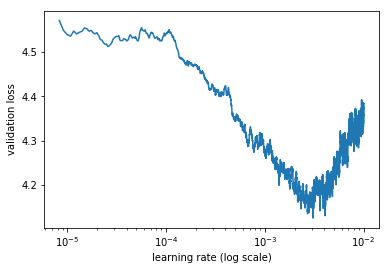

In [25]:
learner.sched.plot()

In [ ]:
learner.fit(lrs, 1, wds=wd, use_clr=(20,10), cycle_len=15)

epoch      trn_loss   val_loss   accuracy                       
    0      3.954851   3.754965   0.356587  
 62%|██████▏   | 7437/11992 [15:57<09:46,  7.77it/s, loss=3.85]

In [ ]:
learner.save('lm1')

In [ ]:
learner.save_encoder('lm1_enc')

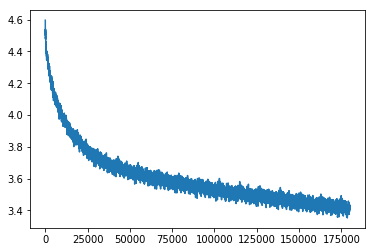

In [33]:
learner.sched.plot_loss()

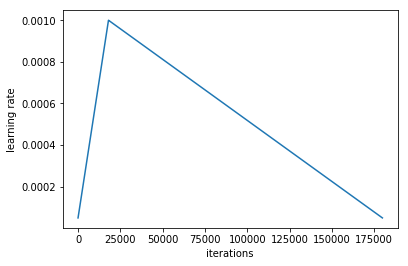

In [34]:
learner.sched.plot_lr()

## Classifier Tokens

In [40]:
df_trn = pd.read_csv(CLAS_PATH/'train.csv', header=None, chunksize=chunksize)
df_val = pd.read_csv(CLAS_PATH/'test.csv', header=None, chunksize=chunksize)

In [41]:
tok_trn, trn_labels = get_all(df_trn, 1)
tok_val, val_labels = get_all(df_val, 1)

0
1
2
3
4
5
6
0
1


In [43]:
(len(tok_trn), len(tok_val))

(148805, 37202)

In [44]:
(CLAS_PATH/'tmp').mkdir(exist_ok=True)

np.save(CLAS_PATH/'tmp'/'tok_trn.npy', tok_trn)
np.save(CLAS_PATH/'tmp'/'tok_val.npy', tok_val)

np.save(CLAS_PATH/'tmp'/'trn_labels.npy', trn_labels)
np.save(CLAS_PATH/'tmp'/'val_labels.npy', val_labels)

In [45]:
tok_trn = np.load(CLAS_PATH/'tmp'/'tok_trn.npy')
tok_val = np.load(CLAS_PATH/'tmp'/'tok_val.npy')

In [5]:
itos = pickle.load((LM_PATH/'tmp'/'itos.pkl').open('rb'))
stoi = collections.defaultdict(lambda:0, {v:k for k,v in enumerate(itos)})
len(itos)

60002

In [47]:
trn_clas = np.array([[stoi[o] for o in p] for p in tok_trn])
val_clas = np.array([[stoi[o] for o in p] for p in tok_val])

In [48]:
np.save(CLAS_PATH/'tmp'/'trn_ids.npy', trn_clas)
np.save(CLAS_PATH/'tmp'/'val_ids.npy', val_clas)

## Classifier

In [6]:
trn_clas = np.load(CLAS_PATH/'tmp'/'trn_ids.npy')
val_clas = np.load(CLAS_PATH/'tmp'/'val_ids.npy')

In [7]:
trn_labels = np.squeeze(np.load(CLAS_PATH/'tmp'/'trn_labels.npy'))
val_labels = np.squeeze(np.load(CLAS_PATH/'tmp'/'val_labels.npy'))
print('{}, {}'.format(len(trn_labels), len(val_labels)))

148805, 37202


In [8]:
bptt,em_sz,nh,nl = 70,400,1150,3
vs = len(itos)
opt_fn = partial(optim.Adam, betas=(0.8, 0.99))
bs = 10

In [9]:
min_lbl = trn_labels.min()
trn_labels -= min_lbl
val_labels -= min_lbl
c=int(trn_labels.max())+1

In [10]:
trn_ds = TextDataset(trn_clas, trn_labels)
val_ds = TextDataset(val_clas, val_labels)
trn_samp = SortishSampler(trn_clas, key=lambda x: len(trn_clas[x]), bs=bs//2)
# trn_samp = SortSampler(trn_clas, key=lambda x: len(trn_clas[x]))
val_samp = SortSampler(val_clas, key=lambda x: len(val_clas[x]))
trn_dl = DataLoader(trn_ds, bs//2, transpose=True, num_workers=1, pad_idx=1, sampler=trn_samp)
val_dl = DataLoader(val_ds, bs, transpose=True, num_workers=1, pad_idx=1, sampler=val_samp)
md = ModelData(PATH, trn_dl, val_dl)

In [11]:
dps = np.array([0.4,0.5,0.05,0.3,0.4])*0.5

In [12]:
m = get_rnn_classifier(bptt, 20*70, c, vs, emb_sz=em_sz, n_hid=nh, n_layers=nl, pad_token=1,
          layers=[em_sz*3, 50, c], drops=[dps[4], 0.1],
          dropouti=dps[0], wdrop=dps[1], dropoute=dps[2], dropouth=dps[3])

In [17]:
for c in m.children():
    print(hasattr(c, 'reset'))
    print('\nWOW\n')

True

WOW

False

WOW



In [19]:
hasattr(m[0], 'reset')

True

In [95]:
opt_fn = partial(optim.Adam, betas=(0.7, 0.99))

In [96]:
learn = RNN_Learner(md, TextModel(to_gpu(m)), opt_fn=opt_fn)
learn.reg_fn = partial(seq2seq_reg, alpha=2, beta=1)
learn.clip=25.
learn.metrics = [accuracy]

In [97]:
lr=3e-3
lrm = 2.6
lrs = np.array([lr/(lrm**4), lr/(lrm**3), lr/(lrm**2), lr/lrm, lr])

In [98]:
lrs=np.array([1e-4,1e-4,1e-4,1e-3,1e-2])

In [99]:
wd = 1e-7
wd = 0
learn.load_encoder('lm1_enc')

In [100]:
learn.freeze_to(-1)

In [ ]:
learn.lr_find(lrs/1000)
learn.sched.plot()

In [ ]:
learn.fit(lrs, 1, wds=wd, cycle_len=1, use_clr=(8,3))

In [64]:
learn.save('clas_0_bs10')

In [65]:
learn.load('clas_0_bs10')

In [66]:
learn.freeze_to(-2)

In [67]:
learn.fit(lrs, 1, wds=wd, cycle_len=1, use_clr=(8,3))

epoch      trn_loss   val_loss   accuracy                        
    0      0.395626   0.300746   0.885624  


[array([0.30075]), 0.8856244218086057]

In [68]:
learn.save('clas_1_bs10')

In [102]:
learn.load('clas_1_bs10')

In [103]:
learn.unfreeze()

In [104]:
learn.fit(lrs, 1, wds=wd, cycle_len=4, use_clr=(32,10))

epoch      trn_loss   val_loss   accuracy                          
    0      0.404497   0.422928   0.884361  
    1      0.362728   0.29369    0.898339                          
    2      0.286088   1.149773   0.898178                          
    3      0.29707    0.273647   0.902532                          


[array([0.27365]), 0.9025321147895732]

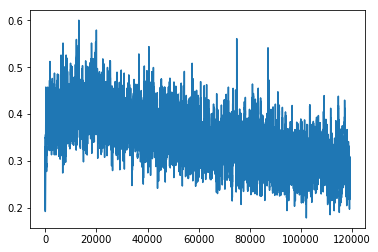

In [105]:
learn.sched.plot_loss()

In [106]:
learn.save('clas_2_bs10_4classifierepochs')

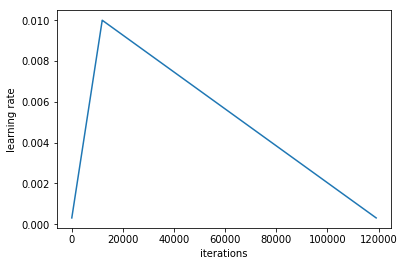

In [107]:
learn.sched.plot_lr()

In [ ]:
# Further train for 2 more epochs
learn.fit(lrs, 1, wds=wd, cycle_len=2, use_clr=(32,10))

epoch      trn_loss   val_loss   accuracy                          
    0      0.364168   0.890275   0.895624  
 78%|███████▊  | 23199/29761 [49:56<14:07,  7.74it/s, loss=0.337] 

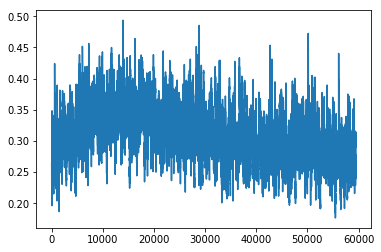

In [117]:
learn.sched.plot_loss()

In [118]:
learn.save('clas_2_bs10_4+2classifierepochs')

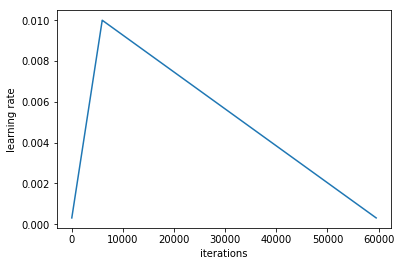

In [119]:
learn.sched.plot_lr()

## Make predictions

In [120]:
%%time

preds, target = learn.predict_with_targs()

CPU times: user 3min 19s, sys: 45 s, total: 4min 4s
Wall time: 4min 4s


In [109]:
# Calcualate the inference times
time_taken = 4 * 60 + 5
time_per_sample = time_taken / len(target)
print('Time per sample: {} s'.format(time_per_sample))
print('Samples per second: {}'.format(1/time_per_sample))

Time per sample: 0.0065856674372345575 s
Samples per second: 151.84489795918367


In [121]:
pred = preds.argmax(axis=1)

In [122]:
from sklearn.metrics import confusion_matrix

In [123]:
conf_mat = confusion_matrix(target, pred, labels = [0, 1, 2])

In [124]:
# funtion to plot confusion matrices, will be needed later

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
        plt.imshow(cm, interpolation='nearest', cmap=cmap, vmin=0, vmax=1)
    else:
        print('Confusion matrix, without normalization')
        plt.imshow(cm, interpolation='nearest', cmap=cmap)

    print(cm)
    
    
    plt.title(title)
    plt.colorbar( )
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Normalized confusion matrix
[[0.91536 0.00273 0.0819 ]
 [0.00508 0.90224 0.09268]
 [0.02185 0.08207 0.89608]]


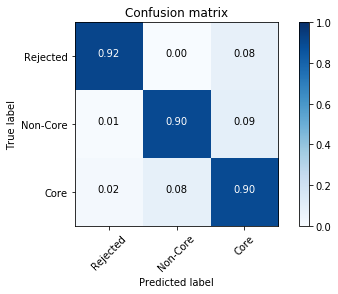

In [127]:
plt.figure()
plot_confusion_matrix(conf_mat, ['Rejected', 'Non-Core', 'Core'], normalize=True)
plt.show()

In [128]:
preds

array([[ -4.70456,   2.7408 ,  -0.32972],
       [ -6.47583,   3.59597,  -1.11337],
       [ -8.7018 ,   2.17497,  -1.86012],
       ...,
       [-11.28339,   1.53921,  -3.40535],
       [ -7.70639,  -0.64722,  -2.76158],
       [ -9.30944,  -1.77991,  -3.42413]], dtype=float32)